In [1]:
from utils import save_submission,load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [2]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    # exponentiate and normalize
    # exp_Z = np.exp(Z)
    # S = exp_Z / exp_Z.sum(axis=1, keepdims=True)
    max_Z = np.max(Z, axis=1, keepdims=True)    # to avoid runtime warnings
    exp_Z = np.exp(Z - max_Z)                   # common problem: overflow, solution: subtract max_Z
    S = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    return S

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [3]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    length = len(Y)
    # calculate predicted values using model
    Z = np.dot(X, model['weight']) + model['bias']
    S = softmax(Z)
    # loss
    loss = S - Y
    # compute gradient of loss with respect to weights
    grad_W = np.dot(X.T, loss) / length
    # compute gradient of loss with respect to bias
    grad_b = np.sum(loss, axis=0) / length
    
    return grad_W, grad_b

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W,grad_b = calcGrad(X,Y,model)
    
    # update weights with gradient descent and L2 regularization
    model['weight'] = (1 - lambda_ * eta) * model['weight'] - eta * grad_W      # not sure if need to divide by n term in regularization
    # update bias
    model['bias'] -= eta * grad_b
    
    return model

In [4]:
def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.3f}'.format(iteration, calc_loss(bX, bY, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model,valError,trainError

In [7]:
data_fn = "nmnist.h5"

print("Load small train.")
Xsmall,Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge,Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval,Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400, 576)
(400, 10)
Load large train.
(7000, 576)
(7000, 10)
Load val.
(2000, 576)
(2000, 10)


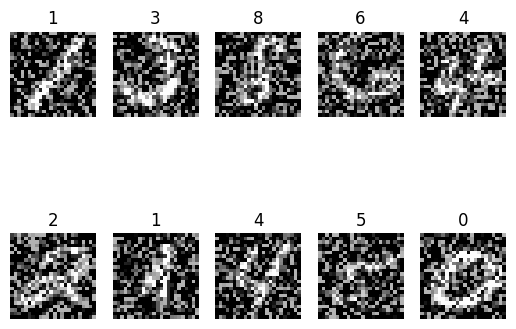

In [8]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

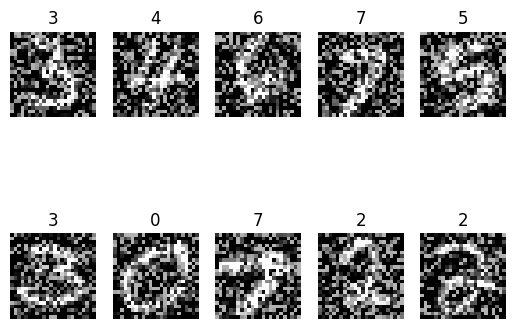

In [9]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [11]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 1,   # initial learning rate
    'maxiter': 100000,   # max number of iterations (updates) of SGD
    'display_iter': 20000,  # display batch loss every display_iter updates
    'batch_size': 10,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .2  # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
lambdas = np.array([0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012, 0.013])

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on small train set
    # note: you need deepcopy here because of the way Python handles copying of complex objects like dictionaries
    # by default, it would copy it by reference, i.e., it would make a new pointer to the same data, so later changing
    # the contents would change the "copied" version as well. deepcopy actually makes a copy.
    trained_model,valErr,trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
    
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on large train set
    trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
    
best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

       0 batch loss: 2.286
   20000 batch loss: 0.104
   40000 batch loss: 0.100
   60000 batch loss: 0.099
   80000 batch loss: 0.099
small train set model: -> lambda= 0.0060, train error: 0.00, val error: 30.70
       0 batch loss: 2.356
   20000 batch loss: 0.101
   40000 batch loss: 0.098
   60000 batch loss: 0.096
   80000 batch loss: 0.095
small train set model: -> lambda= 0.0070, train error: 0.00, val error: 30.90
       0 batch loss: 2.308
   20000 batch loss: 0.161
   40000 batch loss: 0.149
   60000 batch loss: 0.143
   80000 batch loss: 0.140
small train set model: -> lambda= 0.0080, train error: 0.00, val error: 30.85
       0 batch loss: 2.395
   20000 batch loss: 0.196
   40000 batch loss: 0.190
   60000 batch loss: 0.189
   80000 batch loss: 0.189
small train set model: -> lambda= 0.0090, train error: 0.00, val error: 31.00
       0 batch loss: 2.354
   20000 batch loss: 0.242
   40000 batch loss: 0.231
   60000 batch loss: 0.226
   80000 batch loss: 0.221
small train s

Write-Up:

I ended up selecting these lambda values [0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012, 0.013] since appropriate values are typically in the range from 0.001 to 1.0. I started with just 0.001, 0.01, 0.1, and 1.0 and noticed that 0.1 and 1.0 were not preferred, so I explored values in the smaller range, incrementing by 0.001. I included the validation errors for the best lambda values in the output below as well as a plot of the confusion matrix for each. The parameters above ended working the best.
For the training options, I ended up just sticking with the default suggestions as they seemed to work just fine.


Output:

Best small train model val err: 30.65

Best small train model lambda: 0.01

Best large train model val err: 18.05

Best large train model lambda: 0.012


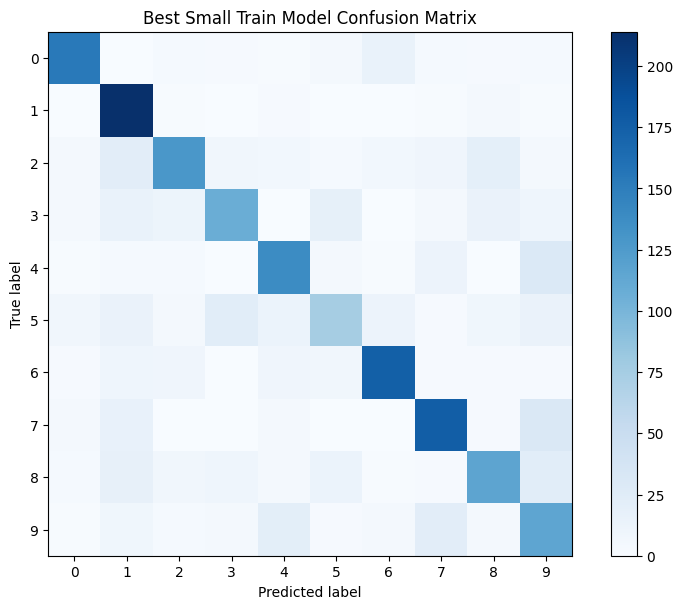

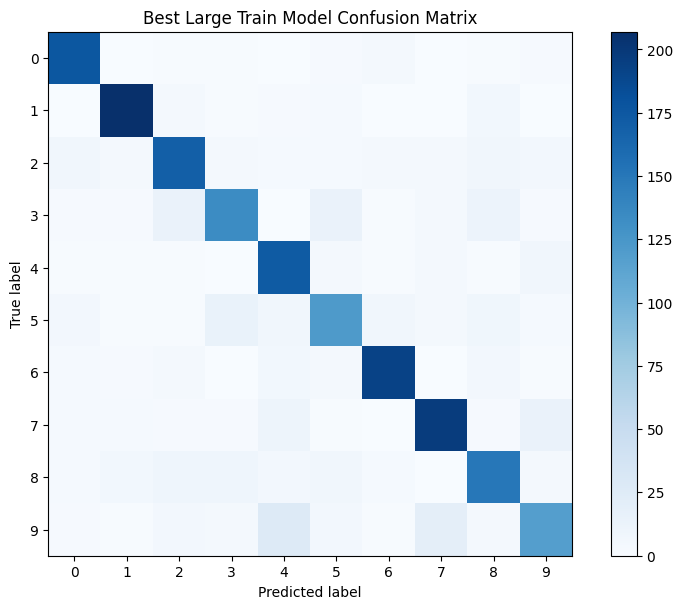

In [12]:
# computes confusion matrices for the best small train model (lambda = 0.010) and best large train model (lambda = 0.012)

from sklearn.metrics import confusion_matrix

# predictions for best small model and best large model
y_pred_small = np.argmax(np.dot(Xval, best_small_trained_model['weight']) + best_small_trained_model['bias'], axis=1)
y_pred_large = np.argmax(np.dot(Xval, best_large_trained_model['weight']) + best_large_trained_model['bias'], axis=1)

# convert true labels to 1D integer array
true_labels = np.argmax(Yval, axis=1)

# compute confusion matrix
cm_small = confusion_matrix(true_labels, y_pred_small)
cm_large = confusion_matrix(true_labels, y_pred_large)

# classes (10 digits)
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm_small, "Best Small Train Model Confusion Matrix")
plt.show()

plot_confusion_matrix(cm_large, "Best Large Train Model Confusion Matrix")
plt.show()


Write-Up:

Below I included plots to visualize the parameters of the learned models for both the best small trained model and best large trained model. The resulting images show different regions in the image that the model asigns different weights. For example, brighter regions in the image indicate the features that the model assigns heavier weights or more importance when making predictions. Darker regions represent features that the model considers less relevant when making predictions for a specific class (digit).

The small and large data sets had different lambda models for the best trained models. The best small train model lambda was 0.010 and the best large train model lambda was 0.012. This means that the larger data set needed more regularization (higher lambda) to prevent overfitting to reduce validation error. Additionally, this difference can be seen in the weight images displayed below. The more regularizaed model (best large trained model) has more smoothed images whereas the less regularized model (best small trained model) has more contrasted/grainy images. This is because regularization (higher lambda value) causes weights to be more "even" as there is a heavier penalty on error. This makes the weights more similar and the weight image to appear more smoothed. Regardless, in both sets of weight images, we can tell the general shape of the class (digit), which means that the models have correctly identified which features to weigh more heavily when classifying the specific class (digit).

Best Small Trained Model:


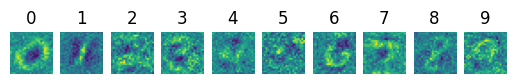

Best Large Trained Model:


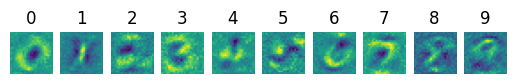

In [13]:
# ignore bias term
W_small = best_small_trained_model['weight']
W_large = best_large_trained_model['weight']

# plot parameters
print(f'Best Small Trained Model:')
for i in range(CLASSES):
    plt.subplot(1, CLASSES, i + 1)
    plt.imshow(W_small[:, i].reshape(24, 24))
    plt.title(f'{i}')
    plt.axis('off')

plt.show()

print(f'Best Large Trained Model:')
for i in range(CLASSES):
    plt.subplot(1, CLASSES, i + 1)
    plt.imshow(W_large[:, i].reshape(24, 24))
    plt.title(f'{i}')
    plt.axis('off')

plt.show()

In [ ]:
#Generate a Kaggle submission file using `model`

#for model trained on small_train
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat_small = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat_small)

#for model trained on large_train
kaggleYhat_large = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat_large)


Saved: submission-small.csv
Saved: submission-large.csv
